In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


import os

# Load data
base_path = "/home/tvanhout/oxides_ML/models/test_training"
# directory = "database_1/ads_height_test_1" # Overfitting
directory = "database_1/cn_std_3_dim_256_2" # Best model database 1 (with cn, surface order 3, tolerance 0.25)
directory = "database_2/surface_order_2_cn" # Best model database 2 (with cn, surface order 2, tolerance 0.25)
directory = "database_3/test" # Best model database 3 (without cn, surface order 2, tolerance 0.3)
# directory = "database_3/segmented"


df_training     = pd.read_csv(os.path.join(base_path, directory , "training.csv"))
df_train_set    = pd.read_csv(os.path.join(base_path, directory , "train_set.csv")) 
df_test_set     = pd.read_csv(os.path.join(base_path, directory , "test_set.csv"))
df_val_set      = pd.read_csv(os.path.join(base_path, directory , "validation_set.csv"))
df_uq           = pd.read_csv(os.path.join(base_path, directory , "uq.csv"))

df_test_set[["Abs_error_eV"]].mean()

Abs_error_eV    0.238424
dtype: float64

## Performance metrics

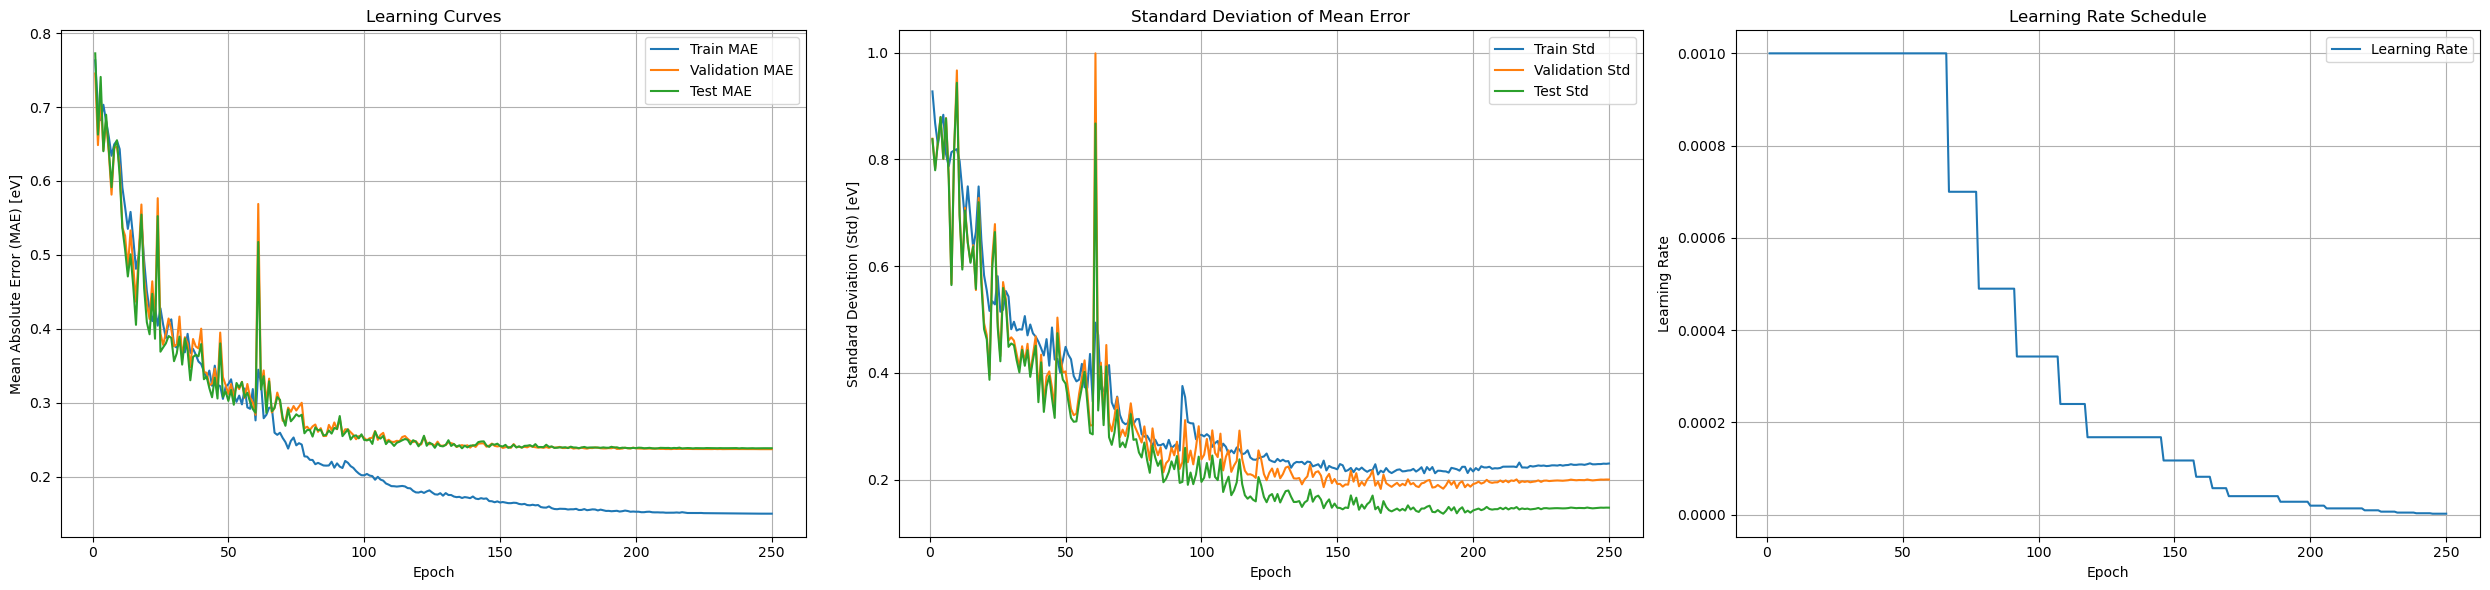

In [2]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))

# Learning Curves (Train, Val, Test MAE)
axs[0].plot(df_training['Epoch'], df_training['Train_MAE_eV'], label='Train MAE')
axs[0].plot(df_training['Epoch'], df_training['Val_MAE_eV'], label='Validation MAE')
axs[0].plot(df_training['Epoch'], df_training['Test_MAE_eV'], label='Test MAE')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Mean Absolute Error (MAE) [eV]')
axs[0].set_title('Learning Curves')
axs[0].legend()
axs[0].grid(True)

# Standard Deviation of Predictions (Train, Val, Test Std)
axs[1].plot(df_training['Epoch'], df_training['Train_std_eV'], label='Train Std')
axs[1].plot(df_training['Epoch'], df_training['Val_std_eV'], label='Validation Std')
axs[1].plot(df_training['Epoch'], df_training['Test_std_eV'], label='Test Std')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Standard Deviation (Std) [eV]')
axs[1].set_title('Standard Deviation of Mean Error')
axs[1].legend()
axs[1].grid(True)

# Learning Rate Schedule
axs[2].plot(df_training['Epoch'], df_training['Learning_Rate'], label='Learning Rate')

axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')
axs[2].set_title('Learning Rate Schedule')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [3]:
# Create subplot figure with 1 row and 3 columns
fig = make_subplots(rows=1, cols=3, subplot_titles=(
    "Learning Curves",
    "Standard Deviation of Mean Error",
    "Learning Rate Schedule"
))

# === Subplot 1: Learning Curves ===
fig.add_trace(go.Scatter(
    x=df_training['Epoch'], y=df_training['Train_MAE_eV'],
    mode='lines', line=dict(color='blue'), name='Train MAE', showlegend=False
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df_training['Epoch'], y=df_training['Val_MAE_eV'],
    mode='lines', line=dict(color='green'), name='Val MAE', showlegend=False
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df_training['Epoch'], y=df_training['Test_MAE_eV'],
    mode='lines', line=dict(color='red'), name='Test MAE', showlegend=False
), row=1, col=1)

# === Subplot 2: Std ===
fig.add_trace(go.Scatter(
    x=df_training['Epoch'], y=df_training['Train_std_eV'],
    mode='lines', line=dict(color='blue'), name='Train Std', showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=df_training['Epoch'], y=df_training['Val_std_eV'],
    mode='lines', line=dict(color='green'), name='Val Std', showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=df_training['Epoch'], y=df_training['Test_std_eV'],
    mode='lines', line=dict(color='red'), name='Test Std', showlegend=False
), row=1, col=2)

# === Subplot 3: LR ===
fig.add_trace(go.Scatter(
    x=df_training['Epoch'], y=df_training['Learning_Rate'],
    mode='lines', line=dict(color='purple'), name='Learning Rate', showlegend=False
), row=1, col=3)

# Annotations for custom legends
fig.update_layout(
    annotations=[
        # Legend 1
        dict(x=0.12, y=1.05, xref='paper', yref='paper',
             text='<span style="color:blue">■</span> Train MAE &nbsp;&nbsp; <span style="color:green">■</span> Val MAE &nbsp;&nbsp; <span style="color:red">■</span> Test MAE',
             showarrow=False, font=dict(size=12)),

        # Legend 2
        dict(x=0.5, y=1.05, xref='paper', yref='paper',
             text='<span style="color:blue">■</span> Train Std &nbsp;&nbsp; <span style="color:green">■</span> Val Std &nbsp;&nbsp; <span style="color:red">■</span> Test Std',
             showarrow=False, font=dict(size=12)),

        # Legend 3
        dict(x=0.86, y=1.05, xref='paper', yref='paper',
             text='<span style="color:purple">■</span> Learning Rate',
             showarrow=False, font=dict(size=12)),
    ]
)

# Layout and axes
fig.update_layout(
    height=600, width=2000, title_text="Performance Metrics Overview", showlegend=False
)

fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_yaxes(title_text="Mean Absolute Error (MAE) [eV]", row=1, col=1)

fig.update_xaxes(title_text="Epoch", row=1, col=2)
fig.update_yaxes(title_text="Standard Deviation (Std) [eV]", row=1, col=2)

fig.update_xaxes(title_text="Epoch", row=1, col=3)
fig.update_yaxes(title_text="Learning Rate", row=1, col=3)

fig.show()

##  Evaluation of the test set

/tmp/ipykernel_871032/2000079371.py:7: UserWarning:

The palette list has more values (10) than needed (2), which may not be intended.



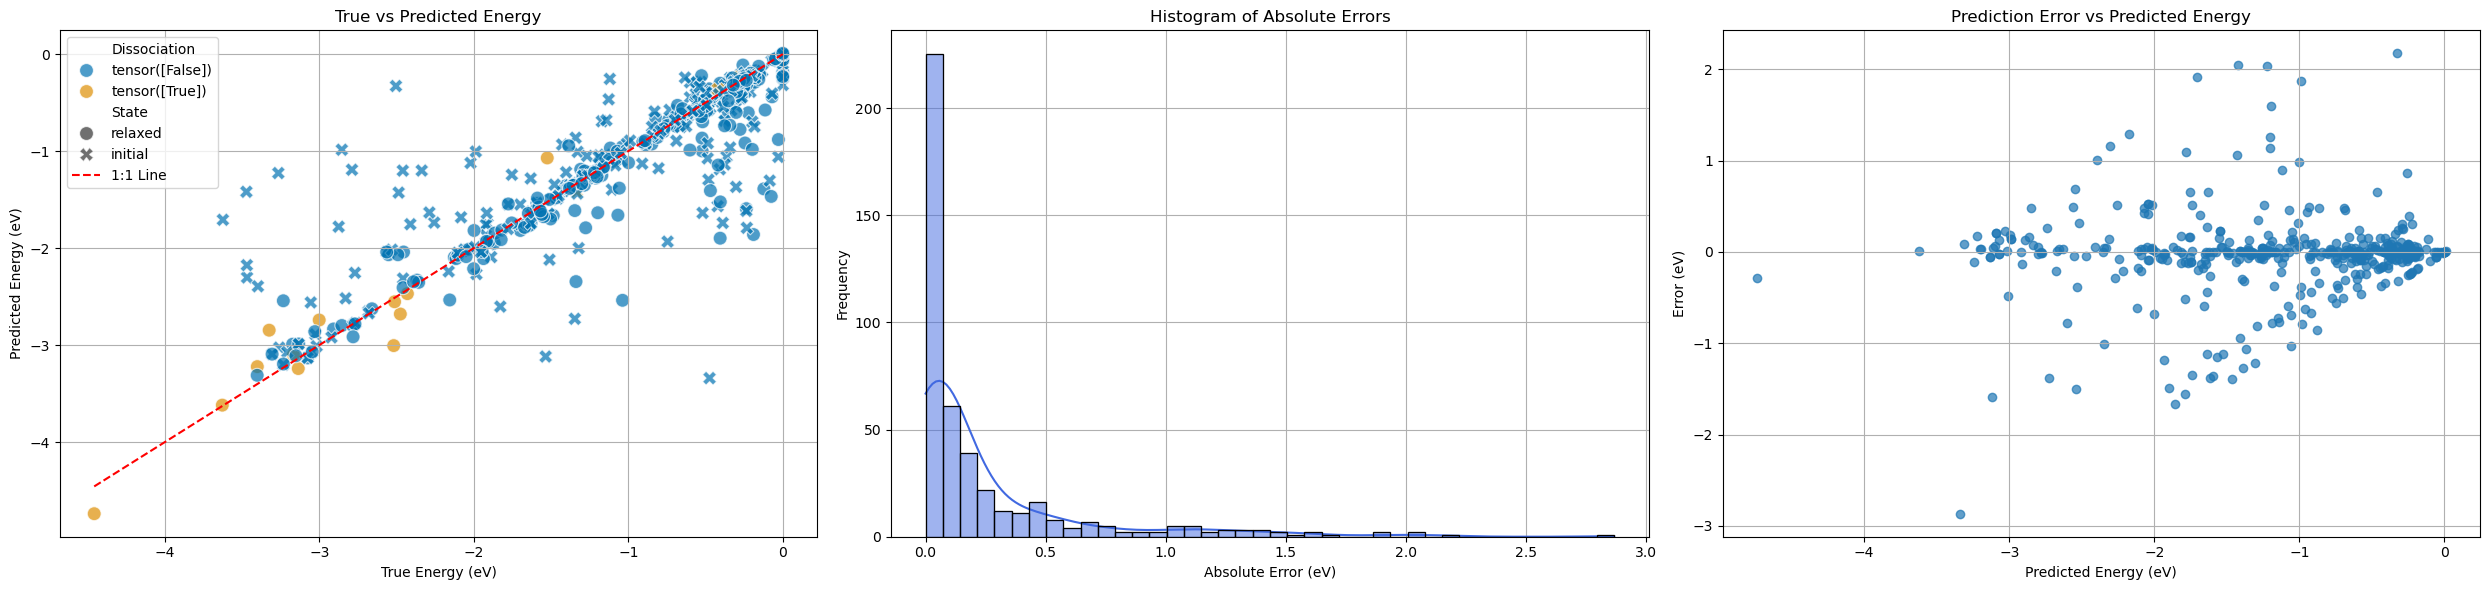

In [4]:
palette = sns.color_palette("colorblind")

fig, axes = plt.subplots(1, 3, figsize=(25, 6))  

# True vs. Predicted Energy Plot
# sns.scatterplot(df_test_set, x='True_eV', y='Prediction_eV', alpha=0.7, hue= "Material", s=100, palette= palette, ax=axes[0])
sns.scatterplot(df_test_set, x='True_eV', y='Prediction_eV', alpha=0.7, hue= "Dissociation", s=100, palette= palette, style = "State", ax=axes[0])
# sns.scatterplot(df_test_set, x='True_eV', y='Prediction_eV', alpha=0.7, hue= "Material", s=100, palette= palette, style = "Dissociation", ax=axes[0])
axes[0].plot([min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             [min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             'r--', label='1:1 Line')
axes[0].set_xlabel('True Energy (eV)')
axes[0].set_ylabel('Predicted Energy (eV)')
axes[0].set_title('True vs Predicted Energy')
axes[0].legend()
axes[0].grid(True)

# Histogram of Absolute Errors
sns.histplot(df_test_set['Abs_error_eV'], bins=40, kde=True, color='royalblue', ax=axes[1], zorder = 10)
axes[1].set_xlabel('Absolute Error (eV)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Absolute Errors')
axes[1].grid(True)

# Prediction Error vs. Predicted Energy
axes[2].scatter(df_test_set['Prediction_eV'], df_test_set['Error_eV'], alpha=0.7)
axes[2].set_xlabel('Predicted Energy (eV)')
axes[2].set_ylabel('Error (eV)')
axes[2].set_title('Prediction Error vs Predicted Energy')
axes[2].grid(True)

plt.tight_layout()
plt.show()


In [5]:
# Color palette
color_map = px.colors.qualitative.Safe

fig = go.Figure()

unique_dissociations = df_test_set["Dissociation"].unique()
unique_states = df_test_set["State"].unique()

for i, diss in enumerate(unique_dissociations):
    for j, state in enumerate(unique_states):
        subset = df_test_set[(df_test_set["Dissociation"] == diss) & (df_test_set["State"] == state)]
        if not subset.empty:
            fig.add_trace(go.Scatter(
                x=subset['True_eV'],
                y=subset['Prediction_eV'],
                mode='markers',
                name=f"{diss}, {state}",
                marker=dict(
                    size=10,
                    color=color_map[i % len(color_map)],
                    symbol=j
                ),
                # Include extra hover fields
                hovertemplate=
                    "<b>Molecule Group:</b> %{customdata[2]}<br>" +
                    "<b>Molecule:</b> %{customdata[3]}<br>" +
                    "<b>State:</b> %{customdata[1]}<br>" +
                    "<b>Dissociation:</b> %{customdata[0]}<br>" +
                    "<b>True Energy:</b> %{x:.3f} eV<br>" +
                    "<b>Predicted:</b> %{y:.3f} eV<br>" +
                    "<extra></extra>",
                customdata=subset[['Dissociation', 'State', 'Molecule Group', 'Molecule']]
            ))

# 1:1 Line
fig.add_trace(go.Scatter(
    x=[df_test_set['True_eV'].min(), df_test_set['True_eV'].max()],
    y=[df_test_set['True_eV'].min(), df_test_set['True_eV'].max()],
    mode='lines',
    name='1:1 Line',
    line=dict(dash='dash', color='red')
))

# Layout
fig.update_layout(
    title='True vs Predicted Energy',
    xaxis_title='True Energy (eV)',
    yaxis_title='Predicted Energy (eV)',
    width=900,
    height=700,
    template='plotly_white'
)

fig.show()

## Uncertainty quantification

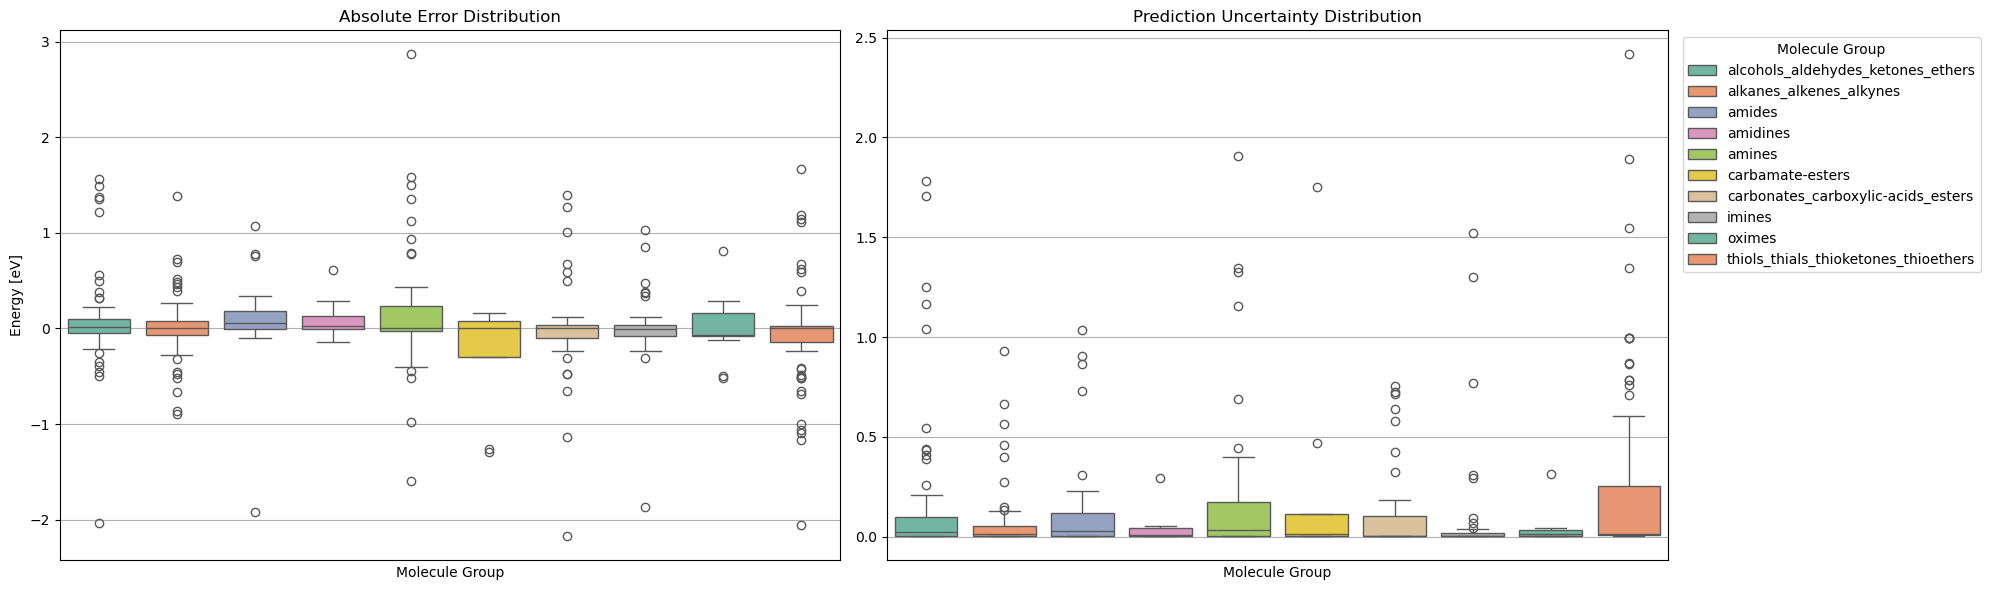

In [6]:
df_uq_sorted = df_uq[df_uq["split"] == "test"].sort_values('molecule_group')

df_uq_sorted['abs_error'] = df_uq_sorted['error'].abs()
df_uq_sorted['uncertainty_width'] = df_uq_sorted['y_std']

# Create subplots with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=False)

# First subplot: Absolute Error
sns.boxplot(data=df_uq_sorted, x='molecule_group', y='error', hue='molecule_group', palette="Set2", legend=False, ax=axes[0])
axes[0].set_xlabel('Molecule Group')
axes[0].set_ylabel('Energy [eV]')
axes[0].set_title('Absolute Error Distribution')
axes[0].set_xticks([])
axes[0].grid(True)

# Second subplot: Uncertainty Width
sns.boxplot(data=df_uq_sorted, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette="Set2", legend=True, ax=axes[1])
axes[1].set_xlabel('Molecule Group')
axes[1].set_ylabel('')  # Shared y-label already on left
axes[1].set_title('Prediction Uncertainty Distribution')
axes[1].set_xticks([])
axes[1].grid(True)
axes[1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


In [7]:
# Filtered data
df_uq_sorted = df_uq[df_uq["split"] == "test"].sort_values('molecule_group')
df_uq_sorted['abs_error'] = df_uq_sorted['error'].abs()
df_uq_sorted['uncertainty_width'] = df_uq_sorted['y_std']

# Custom color palette (Set2-like)
color_map = px.colors.qualitative.Set2

# Create 1x2 subplot
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Absolute Error Distribution", "Prediction Uncertainty Distribution"],
    horizontal_spacing=0.07
)

# Boxplot for absolute error
for i, group in enumerate(df_uq_sorted['molecule_group'].unique()):
    group_data = df_uq_sorted[df_uq_sorted['molecule_group'] == group]
    fig.add_trace(go.Box(
        y=group_data['error'],
        name=group,
        marker_color=color_map[i % len(color_map)],
        boxmean=True,
        boxpoints="all",  # Show all points (can be "outliers", "suspectedoutliers", "all")
        jitter=0.5,  # Add jitter to points
        line=dict(width=3),  # Line width to make the box thicker
        width=0.2,  # Box width (adjust this)
        legendgroup=group,  # Ensure the group is correctly assigned to legend
        showlegend=False,  # No legend for the first plot
        hovertemplate=(
            "Material: %{customdata[7]}<br>" +
            "Molecule Group: %{customdata[0]}<br>" +
            "Molecule: %{customdata[1]}<br>" +
            "State: %{customdata[2]}<br>" +
            "Dissociation: %{customdata[3]}<br>" +
            "True Value: %{customdata[4]} eV<br>" +
            "Std Dev: %{customdata[5]} eV<br>" +
            "Error: %{customdata[6]} eV<br>" +
            "<extra></extra>"
        ),
        customdata=group_data[['molecule_group', 'molecule', 'state', 'dissociation', 'y_true', 'y_std', 'error', 'material']].values  # Add custom data
    ), row=1, col=1)

# Boxplot for uncertainty width
for i, group in enumerate(df_uq_sorted['molecule_group'].unique()):
    group_data = df_uq_sorted[df_uq_sorted['molecule_group'] == group]
    fig.add_trace(go.Box(
        y=group_data['uncertainty_width'],
        name=group,
        marker_color=color_map[i % len(color_map)],
        boxmean=True,
        boxpoints="all",  # Show all points (can be "outliers", "suspectedoutliers", "all")
        jitter=0.5,  # Add jitter to points
        line=dict(width=3),  # Line width to make the box thicker
        width=0.2,  # Box width (adjust this)
        legendgroup=group,  # Ensure the group is correctly assigned to legend
        showlegend=True,  # Show legend for the second plot
        hovertemplate=(
            "Material: %{customdata[7]}<br>" +
            "Molecule Group: %{customdata[0]}<br>" +
            "Molecule: %{customdata[1]}<br>" +
            "State: %{customdata[2]}<br>" +
            "Dissociation: %{customdata[3]}<br>" +
            "True Value: %{customdata[4]} eV<br>" +
            "Std Dev: %{customdata[5]} eV<br>" +
            "Error: %{customdata[6]} eV<br>" +
            "<extra></extra>"
        ),
        customdata=group_data[['molecule_group', 'molecule', 'state', 'dissociation', 'y_true', 'y_std', 'error', 'material']].values  # Add custom data
    ), row=1, col=2)

# Layout adjustments
fig.update_layout(
    height=600,
    width=2000,
    title_text="Absolute Error & Prediction Uncertainty Distributions by Molecular Group",
    template="plotly_white",
    boxmode="group",  # Group the boxplots
    showlegend=True  # Show legend for the second plot
)

# Axis titles
fig.update_yaxes(title_text="Energy [eV]", row=1, col=1)
fig.update_yaxes(title_text="Energy [eV]", row=1, col=2)

# Remove X-axis labels (as you're using the hover to differentiate between groups)
fig.update_xaxes(showticklabels=False, row=1, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=2)

# Show the plot
fig.show()

## Uncertainty Qualification per Surface

In [8]:
df_uq_sorted.groupby('material')['abs_error'].count()

material
Ag       16
Au       18
Cd       16
Co       12
Cu       10
Fe       15
Ir       10
IrO2    105
Ni       11
Os       14
Pd       23
Pt       11
Rh       18
Ru       18
RuO2    117
Zn       19
Name: abs_error, dtype: int64

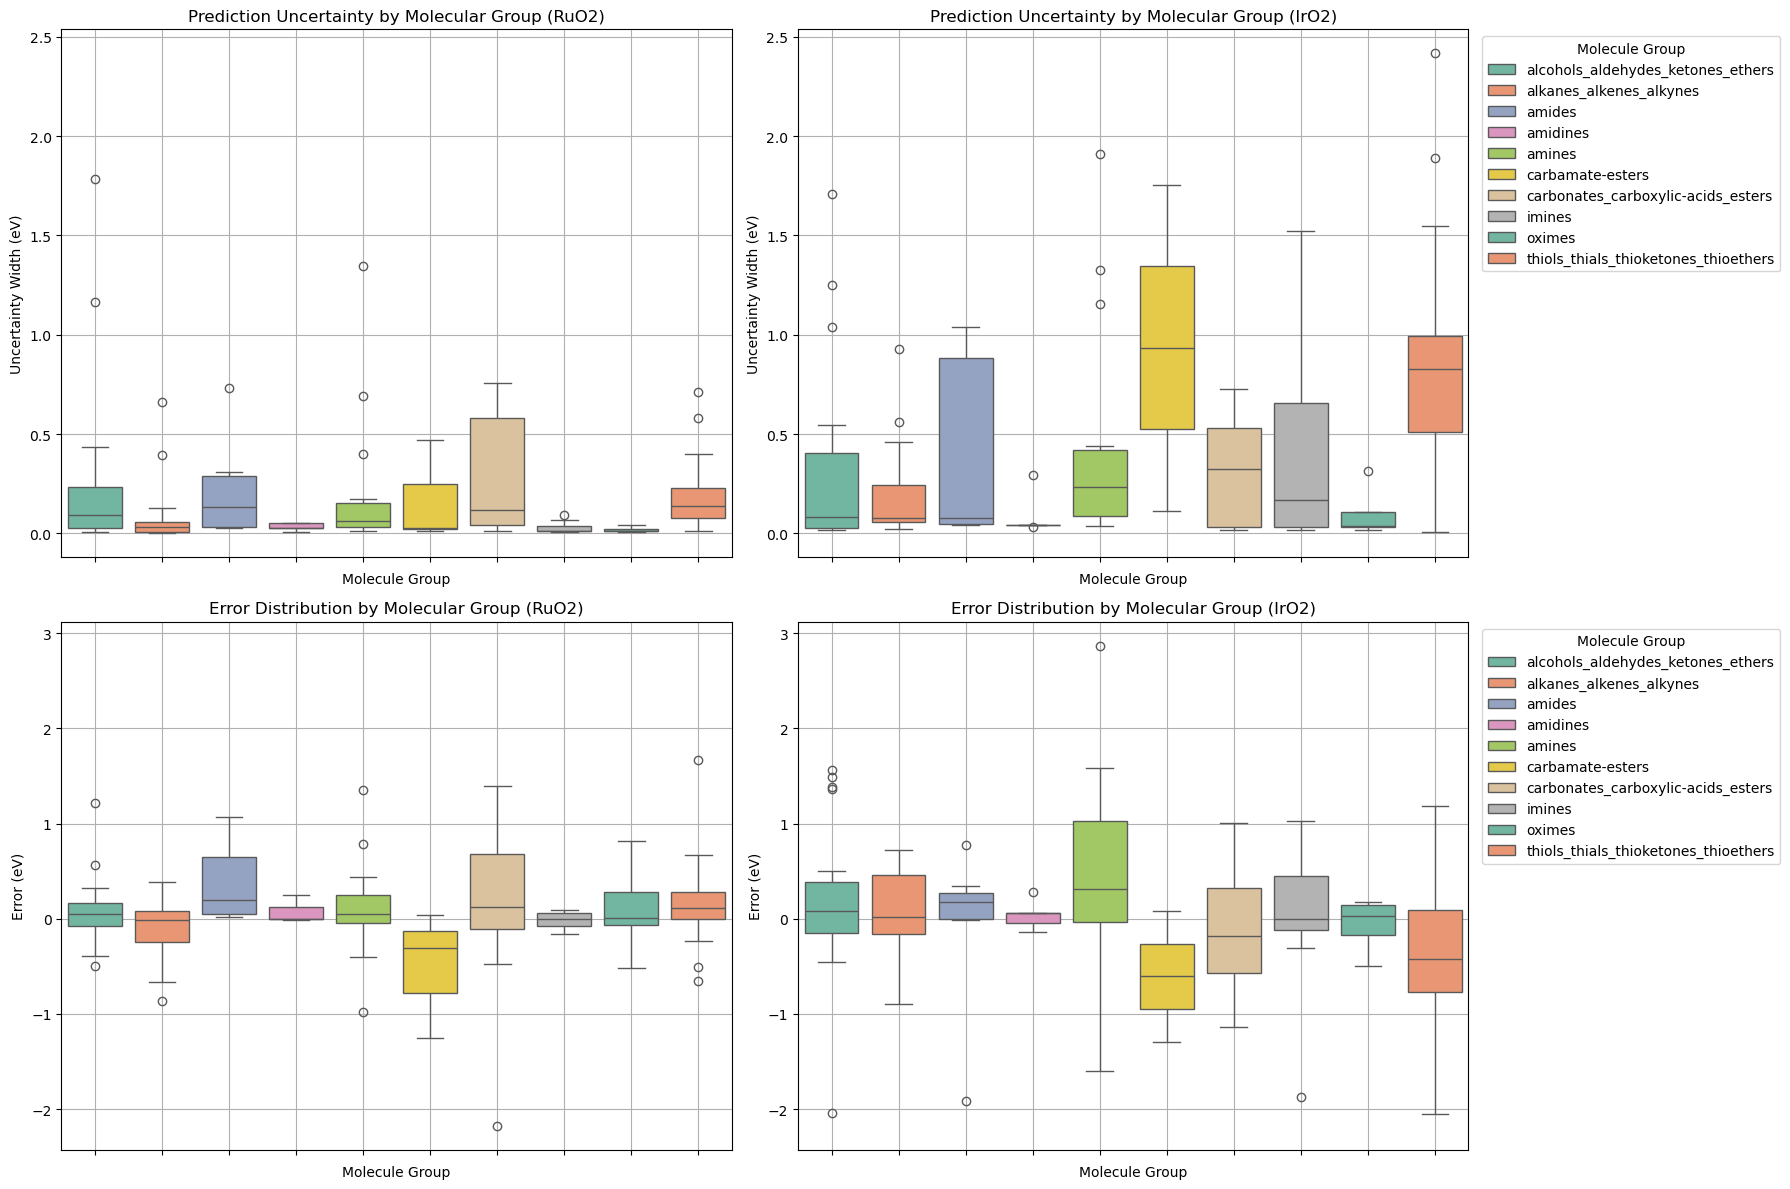

In [9]:
# Filter per material
df_ru = df_uq_sorted[df_uq_sorted['material'] == 'RuO2']
df_ir = df_uq_sorted[df_uq_sorted['material'] == 'IrO2']


# Create figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # 1 row, 2 columns

# RuO2 plot
sns.boxplot(data=df_ru, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette='Set2', legend=False, ax=axes[0,0]
)
axes[0,0].set_title("Prediction Uncertainty by Molecular Group (RuO2)")
axes[0,0].set_xlabel("Molecule Group")
axes[0,0].set_ylabel("Uncertainty Width (eV)")
axes[0,0].set_xticklabels([])
axes[0,0].grid(True)
axes[0,0].sharey(axes[0,1])


# IrO2 plot
sns.boxplot(data=df_ir, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette='Set2', legend=True, ax=axes[0,1])
axes[0,1].set_title("Prediction Uncertainty by Molecular Group (IrO2)")
axes[0,1].set_xlabel("Molecule Group")
axes[0,1].set_ylabel("Uncertainty Width (eV)")
axes[0,1].set_xticklabels([])
axes[0,1].grid(True)
axes[0,1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')

# RuO2 plot
sns.boxplot(data=df_ru, x='molecule_group', y='error', hue='molecule_group', palette='Set2', legend=False, ax=axes[1,0]
)
axes[1,0].set_title("Error Distribution by Molecular Group (RuO2)")
axes[1,0].set_xlabel("Molecule Group")
axes[1,0].set_ylabel("Error (eV)")
axes[1,0].set_xticklabels([])
axes[1,0].grid(True)
axes[1,0].sharey(axes[1,1])


# IrO2 plot
sns.boxplot(data=df_ir, x='molecule_group', y='error', hue='molecule_group', palette='Set2', legend=True, ax=axes[1,1])
axes[1,1].set_title("Error Distribution by Molecular Group (IrO2)")
axes[1,1].set_xlabel("Molecule Group")
axes[1,1].set_ylabel("Error (eV)")
axes[1,1].set_xticklabels([])
axes[1,1].grid(True)
axes[1,1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')



plt.tight_layout()
plt.show()


In [10]:
width = 0.2

# Filtered data
df_ru = df_uq_sorted[df_uq_sorted['material'] == 'RuO2']
df_ir = df_uq_sorted[df_uq_sorted['material'] == 'IrO2']

# Custom color palette (Set2-like)
color_map = px.colors.qualitative.Set2

# Create 2x2 subplot
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        "Prediction Uncertainty by Molecular Group (RuO2)",
        "Prediction Uncertainty by Molecular Group (IrO2)",
        "Error Distribution by Molecular Group (RuO2)",
        "Error Distribution by Molecular Group (IrO2)"
    ],
    horizontal_spacing=0.07,
    vertical_spacing=0.15
)

# Boxplots for uncertainty width (RuO2)
for i, group in enumerate(df_ru['molecule_group'].unique()):
    group_data = df_ru[df_ru['molecule_group'] == group]
    fig.add_trace(go.Box(
        y=group_data['uncertainty_width'],
        name=group,
        marker_color=color_map[i % len(color_map)],
        boxmean=True,
        boxpoints="all",  # Show all points (can be "outliers", "suspectedoutliers", "all")
        jitter=0.5,  # Add jitter to points
        line=dict(width=3),  # Line width to make the box thicker
        width=width,  # Box width (adjust this)
        legendgroup=group,  # Ensure the group is correctly assigned to legend
        showlegend=False,  # Ensure legend is shown for this trace
        hovertemplate=(
            "Molecule Group: %{customdata[0]}<br>" +
            "Molecule: %{customdata[1]}<br>" +
            "State: %{customdata[2]}<br>" +
            "Dissociation: %{customdata[3]}<br>" +
            "True Value: %{customdata[4]} eV<br>" +
            "Std Dev: %{customdata[5]} eV<br>" +
            "Error: %{customdata[6]} eV<br>" +
            "<extra></extra>"
        ),
        customdata=group_data[['molecule_group', 'molecule', 'state', 'dissociation', 'y_true', 'y_std', 'error']].values  # Add custom data
    ), row=1, col=1)

# Boxplots for uncertainty width (IrO2)
for i, group in enumerate(df_ir['molecule_group'].unique()):
    group_data = df_ir[df_ir['molecule_group'] == group]
    fig.add_trace(go.Box(
        y=group_data['uncertainty_width'],
        name=group,
        marker_color=color_map[i % len(color_map)],
        boxmean=True,
        boxpoints="all",  # Show all points (can be "outliers", "suspectedoutliers", "all")
        jitter=0.5,  # Add jitter to points
        line=dict(width=3),  # Line width to make the box thicker
        width=width,  # Box width (adjust this)
        legendgroup=group,  # Ensure the group is correctly assigned to legend
        showlegend=False,  # Don't show legend in the first plot, already shown in the first plot
        hovertemplate=(
            "Molecule Group: %{customdata[0]}<br>" +
            "Molecule: %{customdata[1]}<br>" +
            "State: %{customdata[2]}<br>" +
            "Dissociation: %{customdata[3]}<br>" +
            "True Value: %{customdata[4]} eV<br>" +
            "Std Dev: %{customdata[5]} eV<br>" +
            "Error: %{customdata[6]} eV<br>" +
            "<extra></extra>"
        ),
        customdata=group_data[['molecule_group', 'molecule', 'state', 'dissociation', 'y_true', 'y_std', 'error']].values  # Add custom data
    ), row=1, col=2)

# Boxplots for error (RuO2)
for i, group in enumerate(df_ru['molecule_group'].unique()):
    group_data = df_ru[df_ru['molecule_group'] == group]
    fig.add_trace(go.Box(
        y=group_data['error'],
        name=group,
        marker_color=color_map[i % len(color_map)],
        boxmean=True,
        boxpoints="all",  # Show all points (can be "outliers", "suspectedoutliers", "all")
        jitter=0.5,  # Add jitter to points
        line=dict(width=3),  # Line width to make the box thicker
        width=width,  # Box width (adjust this)
        legendgroup=group,  # Ensure the group is correctly assigned to legend
        showlegend=False,  # Don't show legend in the second plot, already shown in the first plot
        hovertemplate=(
            "Molecule Group: %{customdata[0]}<br>" +
            "Molecule: %{customdata[1]}<br>" +
            "State: %{customdata[2]}<br>" +
            "Dissociation: %{customdata[3]}<br>" +
            "True Value: %{customdata[4]} eV<br>" +
            "Std Dev: %{customdata[5]} eV<br>" +
            "Error: %{customdata[6]} eV<br>" +
            "<extra></extra>"
        ),
        customdata=group_data[['molecule_group', 'molecule', 'state', 'dissociation', 'y_true', 'y_std', 'error']].values  # Add custom data
    ), row=2, col=1)

# Boxplots for error (IrO2)
for i, group in enumerate(df_ir['molecule_group'].unique()):
    group_data = df_ir[df_ir['molecule_group'] == group]
    fig.add_trace(go.Box(
        y=group_data['error'],
        name=group,
        marker_color=color_map[i % len(color_map)],
        boxmean=True,
        boxpoints="all",  # Show all points (can be "outliers", "suspectedoutliers", "all")
        jitter=0.5,  # Add jitter to points
        line=dict(width=3),  # Line width to make the box thicker
        width=width,  # Box width (adjust this)
        legendgroup=group,  # Ensure the group is correctly assigned to legend
        showlegend=False,  # Don't show legend in the second plot, already shown in the first plot
        hovertemplate=(
            "Molecule Group: %{customdata[0]}<br>" +
            "Molecule: %{customdata[1]}<br>" +
            "State: %{customdata[2]}<br>" +
            "Dissociation: %{customdata[3]}<br>" +
            "True Value: %{customdata[4]} eV<br>" +
            "Std Dev: %{customdata[5]} eV<br>" +
            "Error: %{customdata[6]} eV<br>" +
            "<extra></extra>"
        ),
        customdata=group_data[['molecule_group', 'molecule', 'state', 'dissociation', 'y_true', 'y_std', 'error']].values  # Add custom data
    ), row=2, col=2)

# Layout adjustments
fig.update_layout(
    height=1000,
    width=2000,
    title_text="Uncertainty & Error Distributions by Molecular Group",
    template="plotly_white",
    boxmode="group",
    showlegend=True
)

# Axis titles
fig.update_yaxes(title_text="Uncertainty Width (eV)", row=1, col=1)
fig.update_yaxes(title_text="Uncertainty Width (eV)", row=1, col=2)
fig.update_yaxes(title_text="Error (eV)", row=2, col=1)
fig.update_yaxes(title_text="Error (eV)", row=2, col=2)

# Remove X-axis labels and add legend as x-axis replacement
fig.update_xaxes(showticklabels=False, row=1, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=2)
fig.update_xaxes(showticklabels=False, row=2, col=1)
fig.update_xaxes(showticklabels=False, row=2, col=2)

# Show the plot
fig.show()


In [11]:
df_uq[(df_uq["molecule_group"] == "carbamate-esters") & (df_uq["material"] == "Ru")]["split"].unique()

array(['train', 'val'], dtype=object)